In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from mpgm.mpgm.TPGM import TPGM
from mpgm.mpgm.QPGM import QPGM
from mpgm.mpgm.SPGM import SPGM
from mpgm.mpgm.LPGM import LPGM
sns.set_style('darkgrid')

In [2]:
# Path builders.
def get_samples_path(samples_name):
    return 'Samples/' + samples_name + '/'

def get_experiment_path(samples_name, experiment_name):
    return get_samples_path(samples_name) + experiment_name + '/'


# Loading methods.
def load_samples_generator_model(samples_name):
    path = get_samples_path(samples_name)
    
    with open(path + 'generator_model_params.pkl', 'rb') as f:
        generator_model_name = pkl.load(f)
        generator_model_params = pkl.load(f)
    
    return generator_model_name, generator_model_params

def load_samples_graph_generator(samples_name):
    path = get_samples_path(samples_name)
    
    with open(path + 'graph_generator_params.pkl', 'rb') as f:
        graph_generator_name = pkl.load(f)
        graph_generator_params = pkl.load(f)
    
    return graph_generator_name, graph_generator_params

def load_samples_sampling_method(samples_name):
    path = get_samples_path(samples_name)
    
    with open(path + 'sampling_method_params.pkl', 'rb') as f:
        sampling_method_name = pkl.load(f)
        sampling_method_params = pkl.load(f)
    
    return sampling_method_name, sampling_method_params

def load_samples_weight_assigner(samples_name):
    path = get_samples_path(samples_name)
    
    with open(path + 'weight_assigner_params.pkl', 'rb') as f:
        weight_assigner_name = pkl.load(f)
        weight_assigner_params = pkl.load(f)

def load_samples(samples_name):
    path = get_samples_path(samples_name)
    samples = np.load(path + 'samples.npy')
    return samples

def load_samples_generator_model_theta(samples_name):
    path = get_samples_path(samples_name)
    generator_model_theta = np.load(path + 'generator_model_theta.npy')
    return generator_model_theta


def load_experiment_likelihoods(samples_name, experiment_name):
    path = get_experiment_path(samples_name, experiment_name)
    
    with open(path + 'likelihoods.pkl', 'rb') as f:
        likelihoods = pkl.load(f)
    
    return likelihoods

def load_experiment_fit_thetas(samples_name, experiment_name):
    path = get_experiment_path(samples_name, experiment_name)
    
    fit_thetas = np.load(path + 'fit_model_theta.npy')
    
    return fit_thetas

In [3]:
# Data analysis functions.
def apply_function_for_sample_and_experiments(samples_name, experiment_names, function, *function_params):
    result_dict = dict()
    
    for experiment_name in experiment_names:
        result_dict[experiment_name] = function(samples_name, experiment_name, *function_params)
    
    return result_dict

def calculate_tpr_fpr_acc(samples_name, experiment_name, threshold):
    theta_orig = load_samples_generator_model_theta(samples_name)
    theta_fit = load_experiment_fit_thetas(samples_name, experiment_name)
    
    nr_variables = theta_orig.shape[0]

    TN = 0
    TP = 0
    FP = 0
    FN = 0
    for ii in range(1, nr_variables):
        for kk in range(ii):
            real_edge = theta_orig[ii][kk] != 0
            inferred_edge = abs(theta_fit[ii][kk]) >= threshold or abs(theta_fit[kk][ii]) >= threshold

            if real_edge and inferred_edge:
                TP += 1
            elif real_edge and not inferred_edge:
                FN += 1
            elif not real_edge and not inferred_edge:
                TN += 1
            else:
                FP += 1
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    ACC = (TP + TN) / (TP + FP + TN + FN)
    return TPR, FPR, ACC


def is_symmetric(matrix):
    for ii in range(1, len(matrix)):
        for jj in range(ii):
            if(matrix[ii][jj] != matrix[jj][ii]):
                return False
    return True

def calculate_NLL_from_samples(samples_name):
    samples = load_samples(samples_name)
    generator_model_name, generator_model_params = load_samples_generator_model(samples_name)
    theta_orig = load_samples_generator_model_theta(samples_name)
    
    if generator_model_name == 'TPGM':
        model = TPGM(theta_orig, generator_model_params['R'])
    elif generator_model_name == 'QPGM':
        print('Not implemented.')
    elif generator_model_name == 'SPGM':
        print('Not implemented.')
    
    return model.calculate_joint_nll(samples)

def calculate_param_sparsity(samples_name, experiment_name):
    thetas_fit = load_experiment_fit_thetas(samples_name, experiment_name)
    
    total_params = 0
    zero_params = 0
    for ii in range(1, len(thetas_fit)):
        for jj in range(ii):
            total_params += 2
            if thetas_fit[ii][jj] == 0:
                zero_params += 1
            if thetas_fit[jj][ii] == 0:
                zero_params += 1
    
    return 100 * zero_params/total_params

def calculate_NLL_from_experiment(samples_name, experiment_name):
    likelihoods = load_experiment_likelihoods(samples_name, experiment_name)
    joint_NLL = 0
    for likelihood in likelihoods:
        joint_NLL += likelihood[-1]
    return joint_NLL
    
print(calculate_NLL_from_samples('TPGM_burn_in_200_thinning_nr_6400'))
print(calculate_NLL_from_experiment('TPGM_burn_in_200_thinning_nr_6400', 'TPGM_fit_test'))

4.450372069929111
4.744377504170047


In [4]:
# Plotting methods.
def plot_samples_univariate_distr(samples, model_name):
    rows, nr_variables = samples.shape
    ncols = 3
    nrows = nr_variables // 3
    if(nr_variables % 3 != 0):
        nrows += 1
    
    fig = plt.figure(figsize=(12, 15))
    fig.suptitle('Node conditional distributions for a sample from ' + model_name, fontsize=15)
    fig.tight_layout(pad=5.0)
    fig.subplots_adjust(hspace=0.5, wspace=0.3, top=0.95)
    
    #fig.subplots_adjust(hspace=10, wspace=10)
    for idx in range(nr_variables):
        ax = fig.add_subplot(nrows, ncols, idx + 1)
        ax.set_xlabel('Node ' + str(idx+1) + ' values')
        sns.distplot(samples[:, idx], ax=ax)
    plt.show()

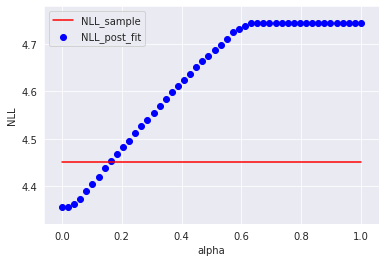

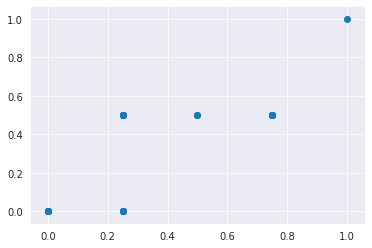

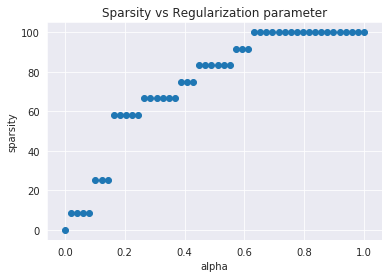

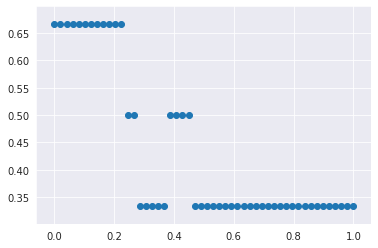

In [47]:
# Miscellaneous functions.
def test_vary_alpha_tpgm():
    alphas = np.linspace(1e-4, 1, 50)
    samples_name = 'TPGM_burn_in_200_thinning_nr_6400'
    #samples_name = 'TPGM_test'
    experiment_names = []
    
    for idx, alpha in enumerate(alphas):
        experiment_name = 'TPGM_fit_test_alpha_' + str(idx)
        experiment_names.append(experiment_name)
    
    likelihoods_dict = apply_function_for_sample_and_experiments(samples_name, experiment_names, calculate_NLL_from_experiment)
    likelihood_samples = calculate_NLL_from_samples(samples_name)
    
    likelihoods = []
    for experiment_name in experiment_names:
        likelihoods.append(likelihoods_dict[experiment_name])
    
    TPR_FPR_ACC_dict = apply_function_for_sample_and_experiments(samples_name, experiment_names, calculate_tpr_fpr_acc, 1e-1)
    TPRs = []
    FPRs = []
    ACCs = []
    for experiment_name in experiment_names:
        TPR, FPR, ACC = TPR_FPR_ACC_dict[experiment_name]
        TPRs.append(TPR)
        FPRs.append(FPR)
        ACCs.append(ACC)
    
    sparsity_dict = apply_function_for_sample_and_experiments(samples_name, experiment_names, calculate_param_sparsity)
    sparsity_vals = []
    for experiment_name in experiment_names:
        sparsity_vals.append(sparsity_dict[experiment_name])
    
    plt.scatter(alphas, likelihoods, color='b', label='NLL_post_fit')
    plt.plot(alphas, np.ones((len(likelihoods), ))*likelihood_samples, color='r', label='NLL_sample')
    plt.legend(loc='upper left')
    plt.xlabel('alpha')
    plt.ylabel('NLL')
    plt.show()
    
    fig, ax = plt.subplots()
    ax.scatter(TPRs, FPRs)
    plt.show()
    
    plt.scatter(alphas, sparsity_vals)
    plt.xlabel('alpha')
    plt.ylabel('sparsity')
    plt.title('Sparsity vs Regularization parameter')
    plt.show()
    
    plt.scatter(alphas, ACCs)
    plt.show()

test_vary_alpha_tpgm()

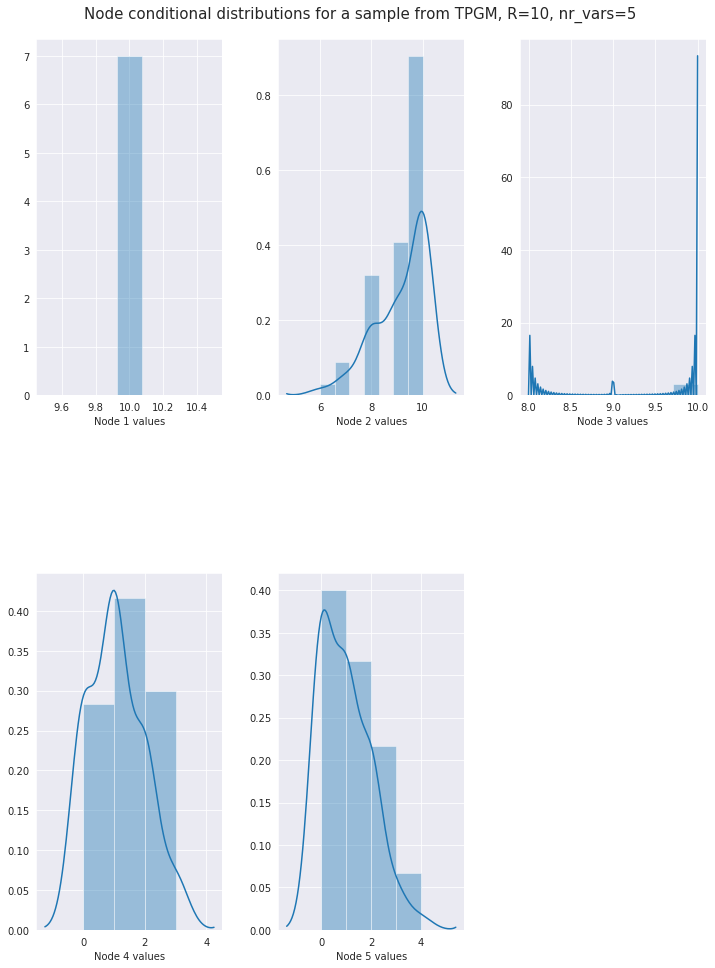

In [90]:
samples_name = 'TPGM_test_moderate_params_sparse'
experiment_name = 'TPGM_fit_test'

samples = load_samples(samples_name)
plot_samples_univariate_distr(samples, 'TPGM, R=10, nr_vars=5')

theta_orig = load_samples_generator_model_theta(samples_name)
theta_fit = load_experiment_fit_thetas(samples_name, experiment_name)

In [91]:
print(theta_orig)

[[0.         0.29546098 0.49263348 0.         0.        ]
 [0.29546098 0.         0.         0.         0.        ]
 [0.49263348 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


In [92]:
print(theta_fit)

[[0.         0.         0.56188083 0.         0.        ]
 [0.27966706 0.         0.01159778 0.         0.        ]
 [0.417982   0.         0.         0.         0.        ]
 [0.         0.         0.00434949 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


In [95]:
print(calculate_tpr_fpr_acc(samples_name, experiment_name, 1e-1))

(1.0, 0.0, 1.0)


In [66]:
# Maybe the parameters are just not sparse enough. ?